# Introduction to NumPyro


In this notebook, we are walking through an introduction on how to use [NumPyro](https://num.pyro.ai/en/latest/getting_started.html) for fitting your data. NumPyro is a probabilistic programming library that offers an interface for defining probabilistic models and running inference algorithms. What does that even mean? Well, that's a good question. Let's break it down a bit.

One of the common algorithms used in NumPyro is the so-called Hamiltonian Monte Carlo, or HMC for short. In contrast to traditional Markov Chain Monte Carlo (MCMC), where we sample from a distribution by constructing a Markov chain with the desired distribution as its equilibrium distribution, HMC relies on physics, in particular, Hamiltonian dynamics. In classical MCMC, we can, for example, use the Metropolis-Hastings algorithm that accepts or rejects a sample based on a certain probability. HMC instead computes the gradient for this new sample and uses auxiliary variables such as a "momentum vector" to increase the acceptance rate. There is a lot more to it, and I recommend reading through [this](https://faculty.washington.edu/yenchic/19A_stat535/Lec9_HMC.pdf) if you are interested.



In [103]:
# The bare necessities:
import numpy as np
import matplotlib.pyplot as plt

# We need to import numpyro first (though we use it last)
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro import distributions as dist
from numpyro.contrib.nested_sampling import NestedSampler, plot_cornerplot

# Set the number of cores on your machine for parallel computing:
cpu_cores = 4
numpyro.set_host_device_count(cpu_cores)

# From jax, we'll import the numpy module as `jnp`:
from jax import numpy as jnp

# The just-in-time decorator:
from jax import jit

# jax has its own scipy module which uses autodiffed gradients
from jax.scipy.optimize import minimize

# random numbers in jax are handled by these:
from jax.random import PRNGKey, split

# jax nested sampling library
import jaxns as jaxns 

# these packages will aid in visualization:
import arviz
from corner import corner


In [104]:
#!pip3 freeze > requirements.txt

______

## A bit about this notebook, the requirements and how to install them

This is how you can install single libraries from your notebook:

```!python3 -m pip install jaxns```

I recommend though that you generate a new python environment, e.g. through conda with python 3.10.11 (which is the version I used), from your terminal.

```conda create --name pycoffee python=3.10```

```conda activate pycoffee ```

Then you can install the requirement files using:

```!python3 -m pip install -r requirements.txt ```

______

In Fred's Python Coffee, you learned about JAX and its magic decorator @jit. Why are we using JAX here?

It exploits autodiff with accelerated linear algebra with a numpy-like API but a just-in-time compiled backend to calculate super fast, differentiable models. 

1) The automatic differentiation allows you to compute gradients of your mathematical models without explicitly deriving gradients for each function. You learned that from Fred last time. These gradients can be used for gradient-based inference techniques like Hamiltonian Monte Carlo.
2) The accelerated linear algebra (XLA) package is an optimising compiler designed for machine learning. You write Python code and it gets just-in-time compiled before you execute it.

NumPyro makes use of the fact that we are compiling our code! Here is a very simple example for fitting a two-component Gaussian (e.g. a blended line)

In [118]:
@jit
def model(params, x):
    
    amp0, amp1, s0, s1, x0, x1 = params
    
    y = (
        amp0 / s0 / (2 * jnp.pi)**0.5  * jnp.exp(-0.5 * (x - x0)**2 / s0**2) + 
        amp1 / s1 / (2 * jnp.pi)**0.5  * jnp.exp(-0.5 * (x - x1)**2 / s1**2) 
        )
    
    return y

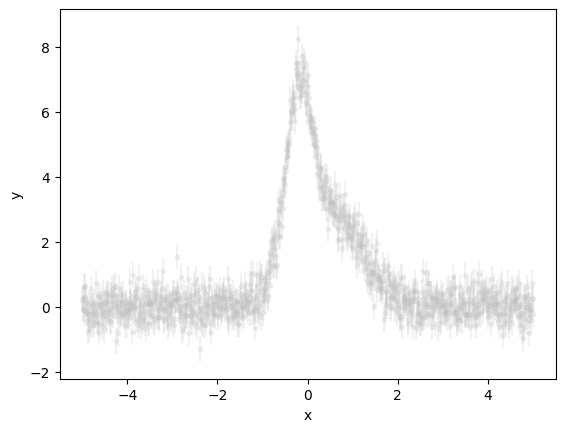

In [125]:
np.random.seed(42)
x = jnp.linspace(-5, 5, 1_000)

# Set the parameters of the double-Gaussian 
# profile in our synthetic data
amp0 = 5
amp1 = 4
x0 = 0.5
x1 = -0.2
s0 = 0.7
s1 = 0.3
yerr = 0.4

truths_model = [amp0, amp1, s0, s1, x0, x1]

y = model(params = truths_model,
          x=x
          ) + np.random.normal(scale=yerr, size=(len(x)))

plt.errorbar(x, y, yerr=yerr, fmt='.', color='silver', alpha=0.2)
plt.gca().set(xlabel='x', ylabel='y');

The cell below now defines the numpyro model that we want to use!

In [127]:
def numpyro_model():
    """
    
    The two Gaussians are defined by an amplitude, mean, and standard deviation.
    
    To find unique solutions for the two Gaussians, we put non-overlapping bounded 
    priors on the two amplitudes, but vary the means and stddev's with identical 
    uniform priors. 
    """
    
    # Uniform priors for amplitudes
    a0 = numpyro.sample('amp0', dist.Uniform(low=3, high=6))
    a1 = numpyro.sample('amp1', dist.Uniform(low=3, high=6))
    
    # Non-overlapping uniform priors for Gaussian means to be able to distinguish the two components
    x0 = numpyro.sample('x0', dist.Uniform(low=0.1, high=2))
    x1 = numpyro.sample('x1', dist.Uniform(low=-1, high=0.1))
    
    # Uniform priors for the stddev's
    s0 = numpyro.sample('sigma0', dist.Uniform(low=0, high=1))
    s1 = numpyro.sample('sigma1', dist.Uniform(low=0, high=1))
    
    # Normally distributed likelihood
    numpyro.sample(
        "obs", dist.Normal(
            loc=model([a0, a1, s0, s1, x0, x1], x), 
            scale=yerr
        ), obs=y
    )


The cell below now defines how we sample and runs the sampler. We pick a No U-Turn Sampler (NUTS), which makes sure our MCMC becomes an HMC, and is probably the most widely used sampler in numpyro I have seen. There are some others that allow you to have models with latent variables, so not observables, but inferred variables, but I have never used them. Check [here](https://num.pyro.ai/en/stable/mcmc.html) for more.

The No U-Turn Sampler is a sampler that does not use the Markov Chain method (what happens next only depends on the status now, random walk), but generates a 'hypothetical' physical system, Hamiltonian mechanics so to say. This hypothetical system can be a ball rolling around with different kinetic energies at different locations. You pick your imaginary system. Important is that the No U-Turn Sampler makes sure that you are not taking a U-Turn. 

If you want to learn more about HMC, I recommend reading [Betancourt 2018](https://arxiv.org/pdf/1701.02434), a conceptual introduction.

In [128]:
# Random numbers in jax are generated like this:
rng_seed = 42
rng_keys = split(
    PRNGKey(rng_seed), 
    cpu_cores
)

# Define a sampler, using here the No U-Turn Sampler (NUTS)
# with a dense mass matrix:
sampler = NUTS(
    numpyro_model, 
    dense_mass=True
)

# Monte Carlo sampling for a number of steps and parallel chains: 
mcmc = MCMC(
    sampler, 
    num_warmup=1_000, 
    num_samples=5_000, 
    num_chains=cpu_cores
)

# Run the MCMC
mcmc.run(rng_keys)

Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]







Running chain 0:   0%|          | 0/6000 [00:05<?, ?it/s]

Running chain 0:  25%|██▌       | 1500/6000 [00:05<00:00, 13852.46it/s]


Running chain 0:  45%|████▌     | 2700/6000 [00:05<00:00, 12515.24it/s]




Running chain 3: 100%|██████████| 6000/6000 [00:05<00:00, 1036.52it/s] 


In [110]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      amp0      5.30      0.27      5.33      4.90      5.74   6203.23      1.00
      amp1      3.67      0.23      3.64      3.30      4.03   6135.07      1.00
    sigma0      0.72      0.02      0.72      0.68      0.75   7773.68      1.00
    sigma1      0.29      0.01      0.28      0.27      0.30   7504.31      1.00
        x0      0.46      0.04      0.45      0.39      0.52   6511.16      1.00
        x1     -0.20      0.01     -0.20     -0.21     -0.19  23206.79      1.00

Number of divergences: 0


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

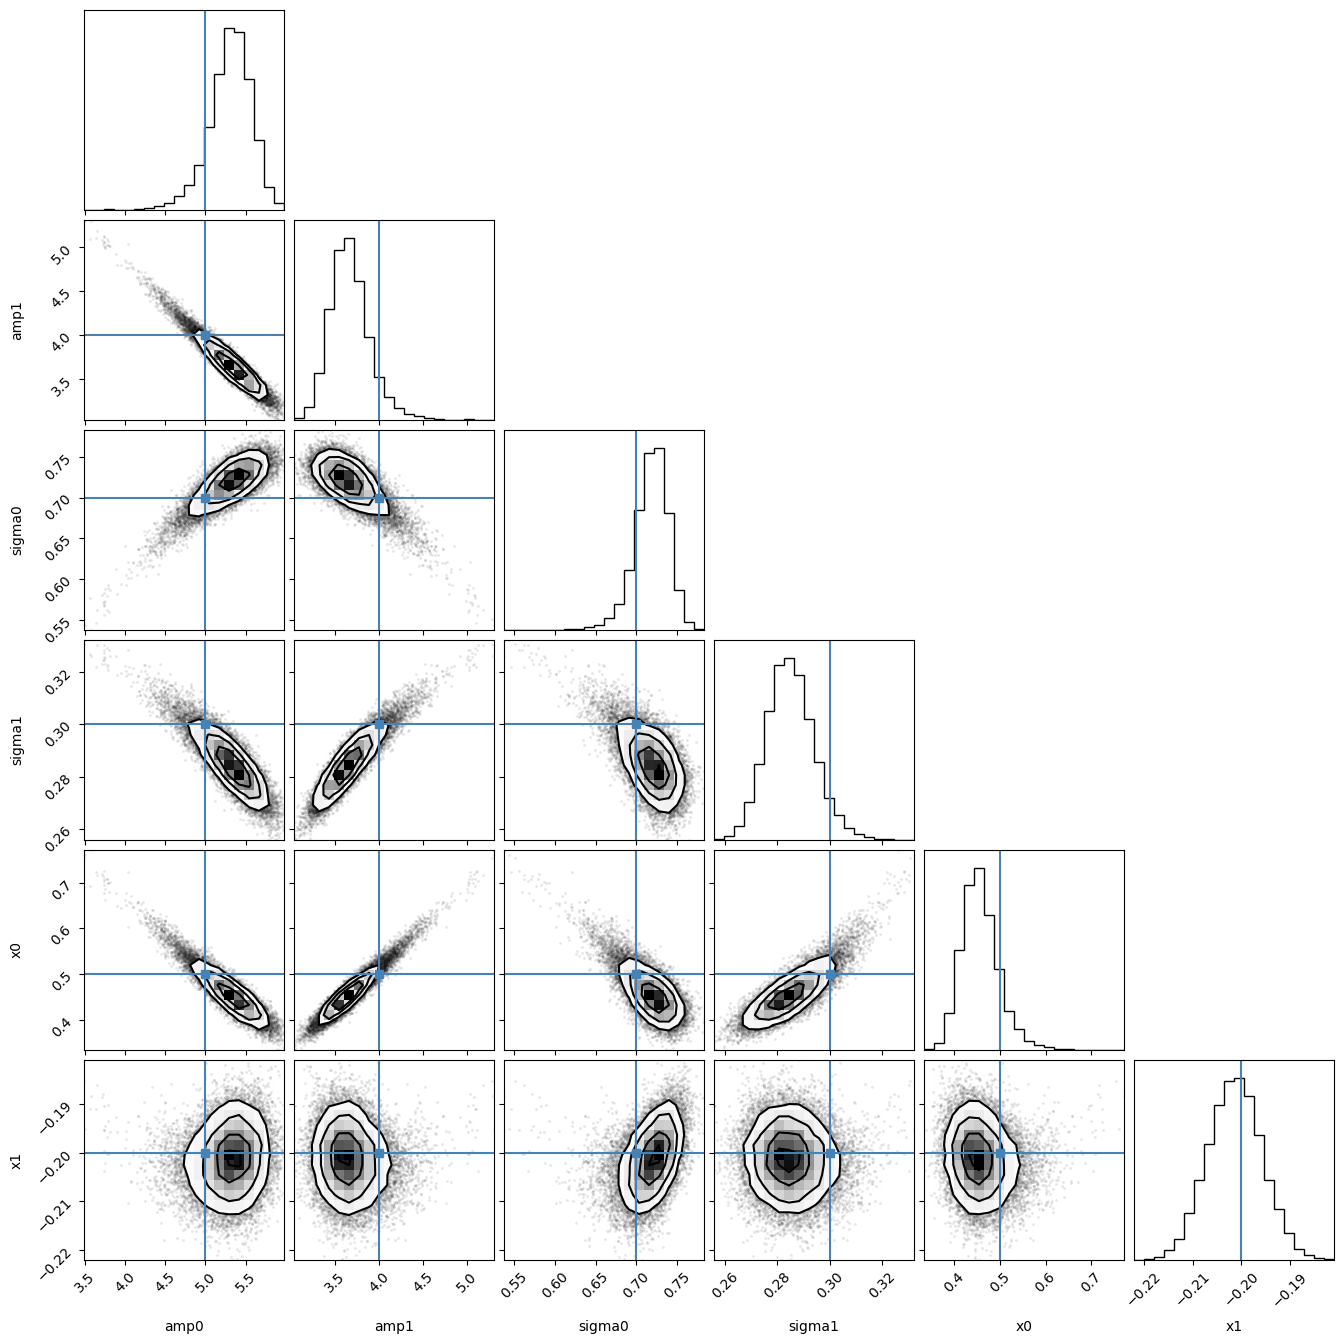

In [131]:
# arviz converts a numpyro MCMC object to an `InferenceData` object based on xarray:
result = arviz.from_numpyro(mcmc)

# make a corner plot
corner(
    result, 
    quiet=True, 
    truths=truths_model,
    #quantiles=[0.16,0.5, 0.84]
);

result

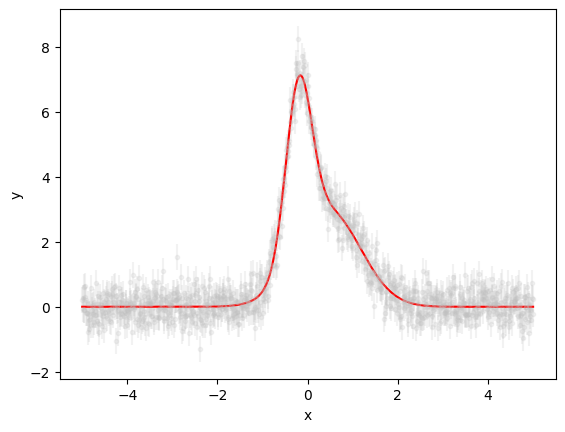

In [132]:
posteriors = result['posterior']

# Extract best-fit
amp0_fit = posteriors['amp0'].mean().to_numpy()
amp1_fit = posteriors['amp1'].mean().to_numpy()
s0_fit = posteriors['sigma0'].mean().to_numpy()
s1_fit = posteriors['sigma1'].mean().to_numpy()
x0_fit = posteriors['x0'].mean().to_numpy()
x1_fit = posteriors['x1'].mean().to_numpy()

# Model best-fit
y_fit = model(
    params=[amp0_fit, amp1_fit, s0_fit, s1_fit, x0_fit, x1_fit],
    x=x
)
plt.figure()
plt.errorbar(x, y, yerr=yerr, fmt='.', color='silver', alpha=0.2)
plt.plot(x, y_fit, color='red')
plt.gca().set(xlabel='x', ylabel='y');

Contrary to classical MCMC, we also get the log likelihood. This gives you the estimator (the evidence) for the goodness of fit. If you e.g. fit two different models to your data, this evidence will tell you which model is better (bigger likelihood, the better it is).

Another example with jax is nested sampling, which tbh is very similar to HMC in terms of running a log likelihood maximisation in the background. Contrary to e.g. pymultinest, you don't have to actually 'define' your log likelihood yourself, but jaxns, the nested sampling library, does this for you. So **IF** your model is auto-differentiable this could be an alternative for you. Let me quickly go through this as well.

The call is very simple, you give it the model, tell it the number of livepoints and go. You can also set max samples (I recommend doing that because the default is 5 x number of dimensions, so rather low). There are different termination conditions, like maximum samples reached, small remaining evidence (we are moving away from the max likelihood so it's not worth looking through it).  

The cell below calls the nested sampler for you and prints a summary, which I find very useful. Let's look at it together! You will see that this takes longer to run than the NUTS HMC above. Why? I am not parallelising this over multiple cores!

In [133]:
ns = NestedSampler(numpyro_model, constructor_kwargs={'num_live_points':3000, 'max_samples':1e5})
ns.run(PRNGKey(10))

ns.print_summary()
ns.diagnostics()

INFO:jaxns:Number of parallel Markov-chains set to: 3000


In [ ]:
def maxlogL(results, variables):
    
    samples = results.samples
    num_samples = results.total_num_samples
    leaves = np.concatenate(
        [np.asarray(samples[key]).reshape((num_samples, -1)) for key in variables],
        axis=-1
    )
    
    # Create a parameter for each column. For scalar parameters, we just use the name of the parameter.
    # For vector we use name[i,j,...] etc.

    # Get the maximum likelihood and MAP samples
    log_L_samples = np.asarray(results.log_L_samples)
    log_posterior_density = np.asarray(results.log_posterior_density)
    max_like_idx = np.argmax(log_L_samples)
    map_idx = np.argmax(log_posterior_density)
    max_like_sample = leaves[max_like_idx]
    map_sample = leaves[map_idx]
    
    return max_like_sample #, map_sample

[5, 0.5, 0.7, 4, -0.2, 0.3] [ 5.4044976   3.5651848   0.43973005 -0.20100218  0.72294265  0.28132966]


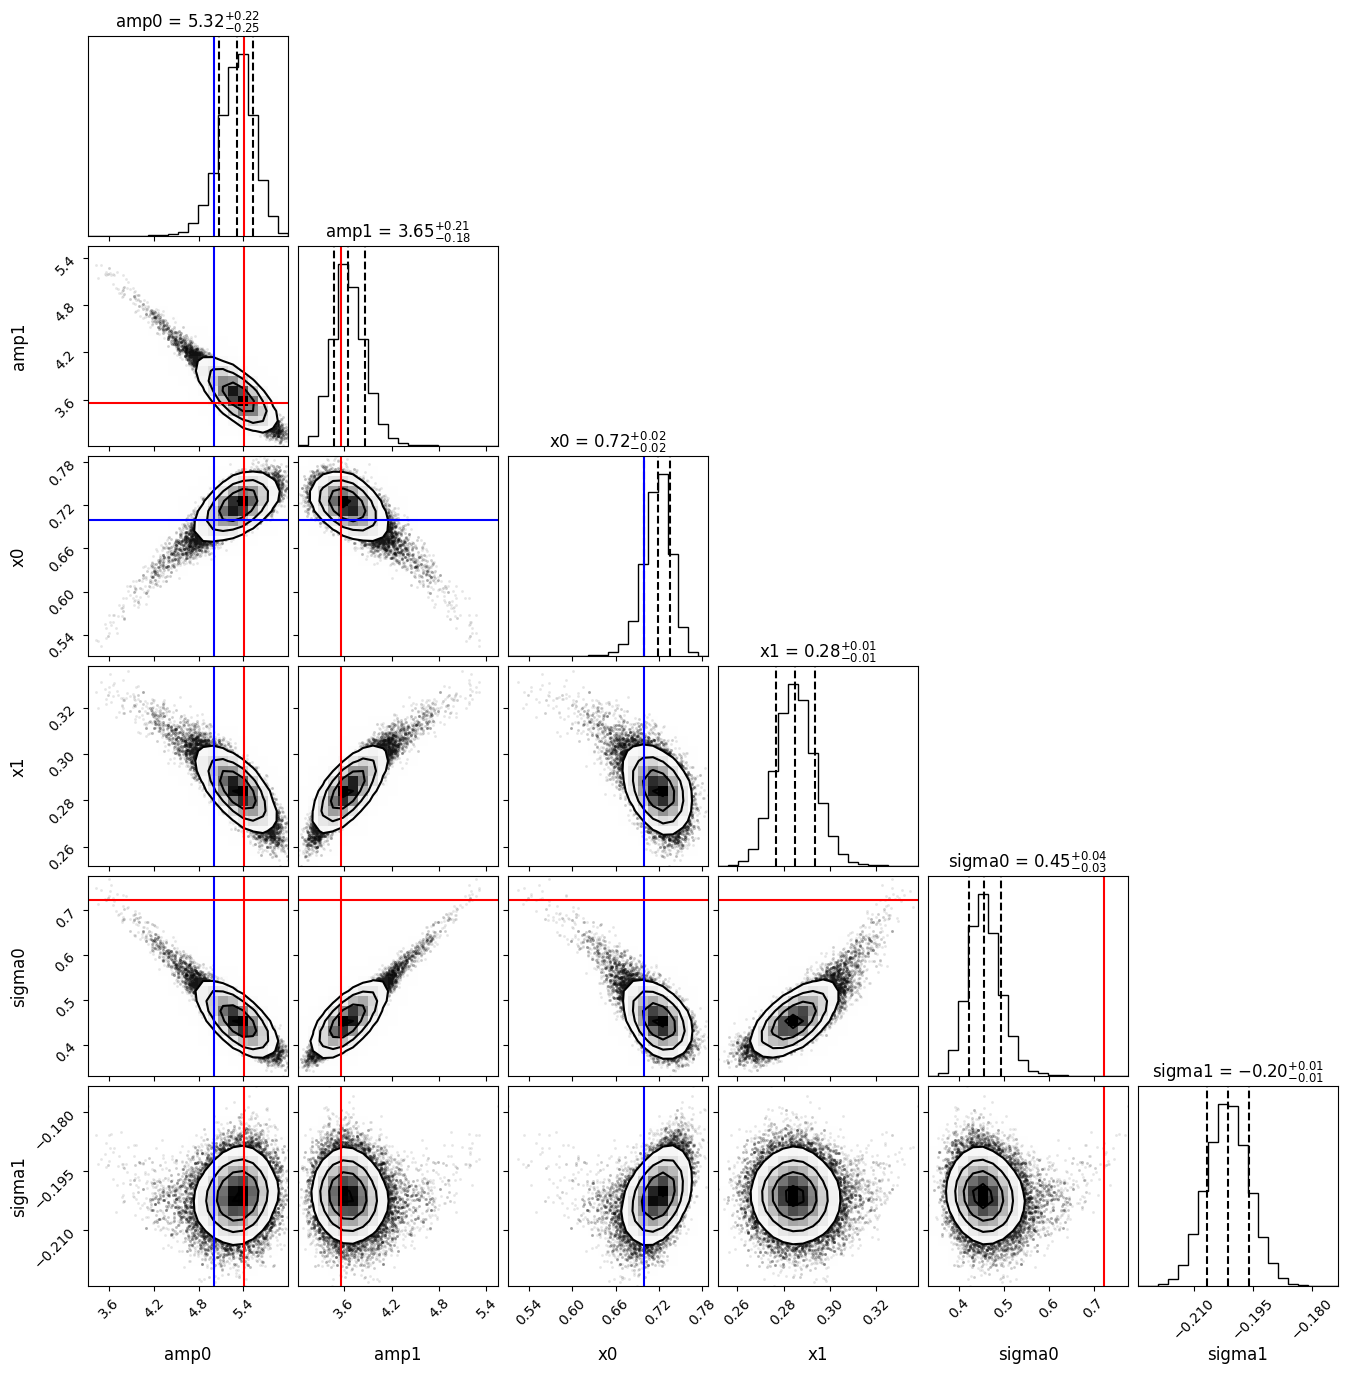

In [117]:
ndim = len(truths_model)
variables = ['amp0', 'amp1', 'sigma0', 'sigma1', 'x0', 'x1']

samples = ns.get_samples(PRNGKey(10), num_samples=ns._results.total_num_samples)

# plot corner
fig = corner(
    samples, 
    quantiles=[0.16,0.5, 0.84],
    labels=variables, 
    plot_contours=True,
    smooth = 1,
    #bins = 100, 
    label_kwargs={'fontsize':12},
    show_titles=True,  
    
);

# Extract max log L estimator: 
max_log_L = maxlogL(ns._results, variables=variables)

# Extract the axes so we can overplot the lines
axes = np.array(fig.axes).reshape((ndim, ndim))

# Loop over the diagonal and plot the truths and max likelihood
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(truths_model[i], color="b")
    ax.axvline(max_log_L[i], color="r")
    
    for k in range(ndim):
        if k==i:
            pass
        elif k>i:
            ax = axes[k, i]
            ax.axvline(truths_model[i], color="b")
            ax.axvline(max_log_L[i], color="r")

            ax.axhline(truths_model[k], color="b")
            ax.axhline(max_log_L[k], color="r")
    
